# The h2o model notebook

- The y-set for location A, B and C are concatonated (time index)
- The X-set for location A, B and C are concatonated (time index)
- One hot encoding for location and whether or not set is from the estimated column
- The y-set and the X-set are merged on date and location
- Having date features
- y-sets are normalized (MinMax)
- Removes repeated values in y-set B and C

It takes over from feature_engineering_1
Adds some ratio features from feature_engineering_3

### Whats new?
Takes over from 155 notebook.

Trains separately for A. Then For B and C, and concatonates them.

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [39]:
train_a = pd.read_parquet('../../../A/train_targets.parquet')
train_b = pd.read_parquet('../../../B/train_targets.parquet')
train_c = pd.read_parquet('../../../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../../../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../../../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../../../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../../../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../../../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../../../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../../../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../../../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../../../C/X_test_estimated.parquet')

## Handling the Y-set

In [40]:
def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True

    return sorted(intervals, key=lambda t: t[1] - t[0], reverse=True)

In [41]:
all_y = [train_a, train_b, train_c]
labels = ['A', 'B', 'C']

table = {}

i = 0
for y in all_y:
    loc, intervals = labels[i], find_repeated_rows(y)
    if isinstance(intervals[0], (int, float)):
        intervals = np.asarray(intervals, dtype=float)
    intervals = list(intervals) + [np.nan] * (1421 - len(intervals))
    table[loc] = intervals
    print("The largest interval for", loc, intervals[0])
    i += 1

table = pd.DataFrame(table)
table.head()

The largest interval for A (5176, 5218)
The largest interval for B (13409, 14466)
The largest interval for C (18105, 18727)


,A,B,C
0,"(5176, 5218)","(13409, 14466)","(18105, 18727)"
1,"(4526, 4547)","(19138, 20141)","(26048, 26669)"
2,"(22429, 22450)","(18690, 19137)","(27224, 27748)"
3,"(22933, 22954)","(10966, 11307)","(25400, 25876)"
4,"(67, 87)","(26115, 26353)","(10047, 10375)"


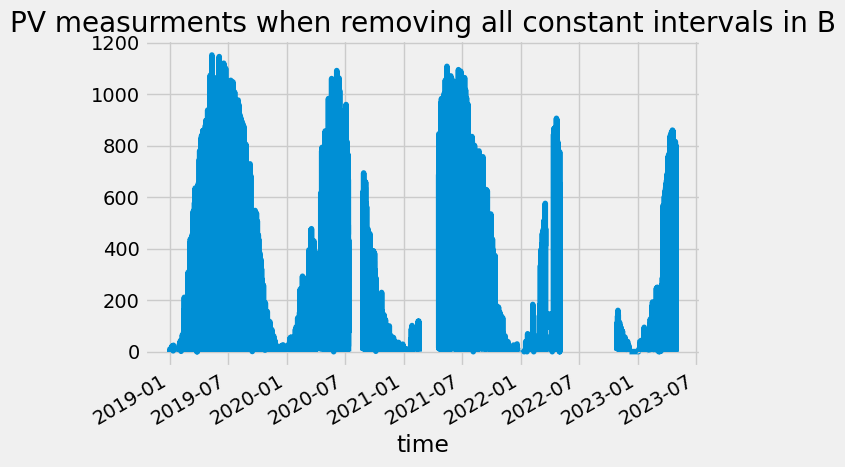

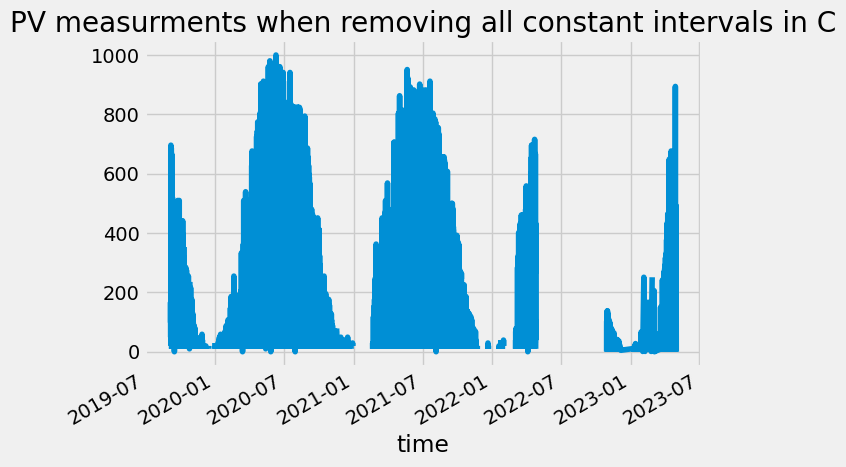

In [42]:
i = 1
for y in all_y[1:]:
    loc, intervals = labels[i], find_repeated_rows(y)
    for start, end in intervals:
        for row_index in range(start, end + 1):
            y.at[row_index, 'pv_measurement'] = np.nan

    test = y.set_index('time')
    test['pv_measurement'].plot(title="PV measurments when removing all constant intervals in " + loc)
    plt.show()
    i += 1

In [43]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

Normalizing values

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

In [45]:
train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

In [46]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [47]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'
y = pd.get_dummies(y, prefix='location', columns=['location'])
encoded_columns = [col for col in y.columns if 'location_' in col]
y[encoded_columns] = y[encoded_columns].astype(int)

y.shape
y.head()

,pv_measurement,location_A,location_B,location_C
time,,,,
2019-06-02 22:00:00,0.000000,1,0,0
2019-06-02 23:00:00,0.000000,1,0,0
2019-06-03 00:00:00,0.000000,1,0,0
2019-06-03 01:00:00,0.000000,1,0,0
2019-06-03 02:00:00,0.003377,1,0,0


Setting the index to **date_forecast** and resampling with mean.

In [48]:

X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_observed_a.drop("date_calc", axis=1, inplace=True)
X_train_observed_a = X_train_observed_a.resample('60min').mean()


X_train_estimated_a['date_forecast'] = pd.to_datetime(X_train_estimated_a['date_forecast'])
X_train_estimated_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
X_train_estimated_a = X_train_estimated_a.resample('60min').mean()


X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_b:
    X_train_observed_b.drop("date_calc", axis=1, inplace=True)
X_train_observed_b = X_train_observed_b.resample('60min').mean()


X_train_estimated_b['date_forecast'] = pd.to_datetime(X_train_estimated_b['date_forecast'])
X_train_estimated_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_b:
    X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
X_train_estimated_b = X_train_estimated_b.resample('60min').mean()


X_train_observed_c['date_forecast'] = pd.to_datetime(X_train_observed_c['date_forecast'])
X_train_observed_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_c:
    X_train_observed_c.drop("date_calc", axis=1, inplace=True)
X_train_observed_c = X_train_observed_c.resample('60min').mean()


X_train_estimated_c['date_forecast'] = pd.to_datetime(X_train_estimated_c['date_forecast'])
X_train_estimated_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_c:
    X_train_estimated_c.drop("date_calc", axis=1, inplace=True)
X_train_estimated_c = X_train_estimated_c.resample('60min').mean()


In [49]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
X_train_observed_b['location'], X_train_estimated_b['location']= 'B', 'B'
X_train_observed_c['location'], X_train_estimated_c['location']= 'C', 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
X_train_observed_b['estimated'], X_train_estimated_b['estimated'] = 0, 1
X_train_observed_c['estimated'], X_train_estimated_c['estimated'] = 0, 1

In [50]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b,
               X_train_estimated_b, X_train_observed_c, X_train_estimated_c
               ], ignore_index=False)
X = X.sort_index()

One hot encoding on location

In [51]:
# One hot encoding
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

In [52]:
df = pd.merge(y, X, left_on=[y.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,date_calc
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.525,1.23975,1200.675049,0.0,0.0,1200.675049,...,0.0,278.250000,86.324997,16827.800781,2.800,1.175,2.550,0.0,0,NaT
2019-01-01 00:00:00,NaN,0,0,1,5.475,1.24075,1130.025024,0.0,0.0,1130.025024,...,0.0,278.350006,83.824997,16509.250000,2.900,1.125,2.625,0.0,0,NaT
2019-01-01 01:00:00,NaN,0,0,1,5.350,1.24000,1066.674927,0.0,0.0,1066.674927,...,0.0,278.200012,99.074997,13277.525391,3.650,1.425,3.350,0.0,0,NaT
2019-01-01 01:00:00,NaN,0,1,0,5.425,1.23975,1131.424927,0.0,0.0,1131.424927,...,0.0,278.075012,99.074997,12777.449219,3.550,1.525,3.200,0.0,0,NaT
2019-01-01 02:00:00,NaN,0,1,0,5.400,1.23850,1061.000000,0.0,0.0,1061.000000,...,0.1,278.049988,97.925003,11140.500000,4.025,2.150,3.425,0.0,0,NaT


In [53]:
def create_features(df):
    """
    Create Features
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    df['is_weekend'] = (df.index.weekday >= 5).astype(int)
    df['season'] = df.index.month.map(get_season)

    # Set a threshold for sun elevation (in degrees)
    elevation_threshold = 10  

    # Binary feature for significant sun elevation
    df['sun_above_threshold'] = (df['sun_elevation:d'] > elevation_threshold).astype(int)

    # Cosine and sine transformations of sun azimuth
    df['cos_sun_azimuth'] = np.cos(np.radians(df['sun_azimuth:d']))
    df['sin_sun_azimuth'] = np.sin(np.radians(df['sun_azimuth:d']))

    df['interaction_clear_sky_rad_sun_elevation'] = df['clear_sky_rad:W'] * df['sun_elevation:d']
    df['interaction_clear_sky_rad_effective_cloud_cover'] = df['clear_sky_rad:W'] * df['effective_cloud_cover:p']

    df['ratio_clear_sky_rad_to_cloud_cover'] = df['clear_sky_rad:W'] / (df['effective_cloud_cover:p'] + 1e-8)  # added a small number to avoid division by zero

    df['ratio_direct_to_diffuse_rad'] = df['direct_rad:W'] / (df['diffuse_rad:W'] + 1e-8)

    df['ratio_air_density_to_humidity'] = df['air_density_2m:kgm3'] / (df['absolute_humidity_2m:gm3'] + 1e-8)

    df['ratio_wind_speed_10m_to_1000hPa'] = df['wind_speed_v_10m:ms'] / (df['wind_speed_w_1000hPa:ms'] + 1e-8)

    return df

def get_season(month):
    if 3 <= month <= 5:
        return 0  # spring
    elif 6 <= month <= 8:
        return 1  # summer
    elif 9 <= month <= 11:
        return 2  # fall
    else:
        return 3  # winter

df = create_features(df)

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,season,sun_above_threshold,cos_sun_azimuth,sin_sun_azimuth,interaction_clear_sky_rad_sun_elevation,interaction_clear_sky_rad_effective_cloud_cover,ratio_clear_sky_rad_to_cloud_cover,ratio_direct_to_diffuse_rad,ratio_air_density_to_humidity,ratio_wind_speed_10m_to_1000hPa
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.525,1.23975,1200.675049,0.0,0.0,1200.675049,...,3,0,0.935294,0.353871,-0.0,0.0,0.0,0.0,0.224389,255000016.0
2019-01-01 00:00:00,NaN,0,0,1,5.475,1.24075,1130.025024,0.0,0.0,1130.025024,...,3,0,0.935234,0.354030,-0.0,0.0,0.0,0.0,0.226621,262500000.0
2019-01-01 01:00:00,NaN,0,0,1,5.350,1.24000,1066.674927,0.0,0.0,1066.674927,...,3,0,0.762355,0.647159,-0.0,0.0,0.0,0.0,0.231776,335000000.0
2019-01-01 01:00:00,NaN,0,1,0,5.425,1.23975,1131.424927,0.0,0.0,1131.424927,...,3,0,0.762586,0.646886,-0.0,0.0,0.0,0.0,0.228525,320000000.0
2019-01-01 02:00:00,NaN,0,1,0,5.400,1.23850,1061.000000,0.0,0.0,1061.000000,...,3,0,0.532802,0.846240,-0.0,0.0,0.0,0.0,0.229352,342500000.0


### Selecting features

Everything except:

- snow_density:kgm3
- cloud_base_agl:m
- ceiling_height_agl:m

They have a lot of NaN values.

In [54]:
FEATURES = [
    'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
    'clear_sky_energy_1h:J', 'clear_sky_rad:W',
    'dew_or_rime:idx', 'dew_point_2m:K',
    'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
    'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
    'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
    'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
    'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
    'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
    'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
    'snow_depth:cm', 'snow_drift:idx',
    'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
    'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
    'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
    'dayofmonth', 'weekofyear', 'is_weekend', 'season', 'sun_above_threshold',
    'cos_sun_azimuth', 'sin_sun_azimuth', 'interaction_clear_sky_rad_sun_elevation',
    'interaction_clear_sky_rad_effective_cloud_cover',
    'location_A', 'location_B', 'location_C', 'estimated'
]

TARGET = 'pv_measurement'

In [55]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [56]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]

df = df.dropna()
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

absolute_humidity_2m:gm3       72
air_density_2m:kgm3            72
clear_sky_energy_1h:J          72
clear_sky_rad:W                72
dew_or_rime:idx                72
                            ...  
location_A                      0
location_B                      0
location_C                      0
estimated                       0
pv_measurement              43484
Length: 62, dtype: int64
absolute_humidity_2m:gm3    0
air_density_2m:kgm3         0
clear_sky_energy_1h:J       0
clear_sky_rad:W             0
dew_or_rime:idx             0
                           ..
location_A                  0
location_B                  0
location_C                  0
estimated                   0
pv_measurement              0
Length: 62, dtype: int64
DROPNA RESULTED IN 43520 ROWS BEING DROPPED. THE DATASET HAS 55566 ROWS IN TOTAL.


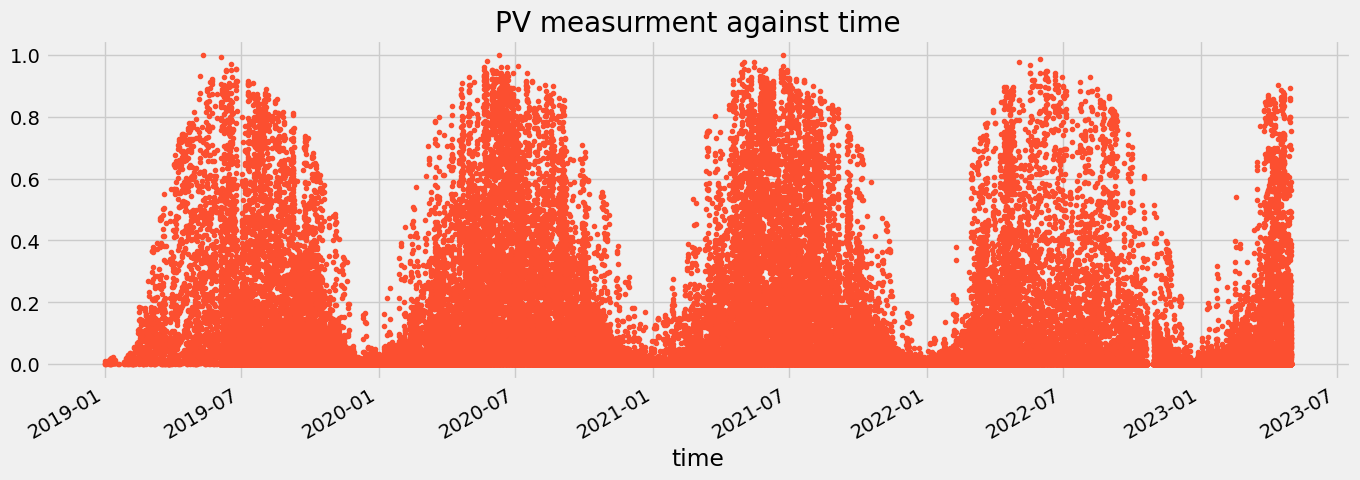

In [57]:
color_pal = sns.color_palette()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()

### Preparing test data

- Excluding dates that should not be tested
- Including only the features we have defined

In [58]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def prepare_test_data(x, location):
    x_test = x.copy()
    x_test.set_index('date_forecast', inplace = True)
    x_test.drop('date_calc', axis=1, inplace = True)
    x_test['estimated'] = 1

    x_test = x_test.resample('60min').mean()

    x_test = create_features(x_test)

    if location == 'A':
        x_test['location_A'] =  1
        x_test['location_B'] = 0
        x_test['location_C'] = 0
    elif location == 'B':
        x_test['location_A'] =  0
        x_test['location_B'] = 1
        x_test['location_C'] = 0
    elif location == 'C':
        x_test['location_A'] =  0
        x_test['location_B'] = 0
        x_test['location_C'] = 1

    return x_test

In [59]:
x_test_a = prepare_test_data(X_test_estimated_a, 'A')
x_test_b = prepare_test_data(X_test_estimated_b, 'B')
x_test_c = prepare_test_data(X_test_estimated_c, 'C')

In [60]:
test_sub = pd.read_csv('../../../test.csv')
valid_dates = pd.to_datetime(test_sub['time'].unique())

In [61]:
x_test_a = x_test_a.loc[valid_dates]
x_test_b = x_test_b.loc[valid_dates]
x_test_c = x_test_c.loc[valid_dates]

In [62]:
X_test_1 = x_test_a
X_test_1 = X_test_1[FEATURES]

In [63]:
X_test_2 = pd.concat([x_test_b, x_test_c])
X_test_2 = X_test_2[FEATURES]

### Disability Check

Check if the training data and the test data contains the same columns.

In [64]:
check_df = df.copy()
check_train = check_df[FEATURES]
if X_test_1.columns.equals(check_train.columns) and X_test_2.columns.equals(check_train.columns):
    print("EQUAL")
else:
    print("NOT EQUAL")
    print("DIFFERENCE EXAMPLE X_TEST_1\n", X_test_1.columns.difference(check_train.columns))

EQUAL


Check if test data has the right amount of rows.

In [65]:
if X_test_1.shape[0] != 720:
    print("X_test_1 has wrong amount of rows!")
    print("Shape =", X_test_1.shape[0])
elif X_test_2.shape[0] != 1440:
    print("X_test_2 has wrong amount of rows!")
    print("Shape =", X_test_2.shape[0])
else:
    print("GOOD")

GOOD


In [104]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 mins 01 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_nickaskari_3npd6p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.000 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Model for A

In [67]:
df_a = df.copy()
df_a = df[df['location_A'] == 1]

In [68]:
hf_1 = h2o.H2OFrame(df_a)
hf_test_1 = h2o.H2OFrame(X_test_1)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [69]:
hf_1.tail()

absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,season,sun_above_threshold,cos_sun_azimuth,sin_sun_azimuth,interaction_clear_sky_rad_sun_elevation,interaction_clear_sky_rad_effective_cloud_cover,location_A,location_B,location_C,estimated,pv_measurement
4.725,1.26275,2.09437e+06,533.125,0,273.05,185.325,790703,184.9,529532,90.3,6,0,0,0,0,0,1,0,1014.22,0,0,1001,1007.2,0,0,67.075,1013.4,0,0,0,0,235.807,31.4113,0,276.7,90.3,21634.3,6.875,6.875,0.15,0,14,6,2,4,2023,120,30,17,1,0,1,-0.56199,-0.827144,16746.1,48141.2,1,0,0,1,0.378612
4.55,1.26425,1.71488e+06,416.3,0,272.55,156.575,615353,158.15,617505,85.025,6,0,0,0,0,0,1,0,1014.28,0,0,1001.07,1007.28,0,0,65.575,1013.47,0,0,0,0,250.919,25.4272,0,276.575,85.025,23465.9,7.075,7.075,0.4,0,15,6,2,4,2023,120,30,17,1,0,1,-0.326901,-0.945059,10585.4,35395.9,1,0,0,1,0.119796
4.475,1.2675,1.26577e+06,285.7,0,272.35,122.125,501633,98.4,461783,83.2,6,0,0,0,0,0,1,0,1014.4,0,0,1001.2,1007.38,0,0,66.75,1013.62,0,0,0,0,264.975,18.88,0,276.175,83.2,23213.1,6.975,6.925,0.55,0,16,6,2,4,2023,120,30,17,1,0,1,-0.0875818,-0.996157,5394.02,23770.2,1,0,0,1,0.158321
4.6,1.27125,792419,156.375,0,272.5,73.75,352587,52.75,272105,88.225,6,0,0,0,0,0,1,0,1014.45,0,0,1001.28,1007.5,0,0,70.9,1013.72,0,0,0,0,278.405,12.1867,0,275.75,88.225,21046.8,6.25,6.175,1.15,0,17,6,2,4,2023,120,30,17,1,0,1,0.146165,-0.98926,1905.7,13796.2,1,0,0,1,0.120794
4.6,1.274,363629,52.875,0,272.5,28.55,184130,7.275,108047,92.575,6,0,0,0,0,0,1,0,1014.6,0,0,1001.4,1007.62,0,0,72.525,1013.88,0,0,0,0,291.613,5.71825,0,275.375,92.575,22678.4,5.675,5.425,1.75,0,18,6,2,4,2023,120,30,17,1,0,0,0.368336,-0.929693,302.352,4894.9,1,0,0,1,0.0339588
4.55,1.2765,84464.9,4.225,0,272.425,2.825,56431.1,0.1,13230.6,96.7,6,0,0,0,0,0,0.5,0.75,1014.75,0,0,1001.57,1007.8,0,0,74.625,1014.05,0,0,0,0,304.939,-0.1805,0,275.025,96.7,23417.1,5.175,4.8,1.925,0,19,6,2,4,2023,120,30,17,1,0,0,0.572707,-0.81976,-0.762612,408.557,1,0,0,1,0.00157323
4.5,1.27975,2270.88,0,0,272.3,0,5067.88,0,176.35,94.225,6,0,0,0,0,0,0,1,1014.7,0,0,1001.55,1007.8,0,0,76.875,1014.05,0,0,0,0,318.626,-5.176,0,274.65,94.525,21084.1,4.65,4.025,2.3,0,20,6,2,4,2023,120,30,17,1,0,0,0.750408,-0.660975,0,0,1,0,0,1,0
4.5,1.281,0,0,0,272.3,0,0,0,0,94.325,6,0,0,0,0,0,0,1,1014.55,0,0,1001.4,1007.67,0,0,77.775,1013.93,0,0,0,0,332.786,-8.95075,0,274.525,95.675,20792.5,4.45,3.575,2.6,0,21,6,2,4,2023,120,30,17,1,0,0,0.889302,-0.45732,0,0,1,0,0,1,0
4.5,1.281,0,0,0,272.3,0,0,0,0,97.775,6,0,0,0,0,0,0,1,1014.4,0,0,1001.25,1007.5,0,0,79,1013.8,0,0,0,0.025,347.378,-11.2332,0.1,274.325,98.875,14158.1,4.1,3.175,2.55,0,22,6,2,4,2023,120,30,17,1,0,0,0.975833,-0.218518,0,0,1,0,0,1,0
4.5,1.281,0,0,0,272.275,0,0,0,0,98.425,6,0,0,0,0,0,0,1,1014.05,0,0,1000.88,1007.1,0,0,79.85,1013.4,0,0,0,0.05,92.2095,-11.8415,0.075,274.225,99.7,11872.3,3.75,2.725,2.55,0,23,6,2,4,2023,120,30,17,1,0,0,-0.0385535,0.999257,0,0,1,0,0,1,0


In [70]:
y = "pv_measurement"
x = hf_1.columns
x.remove(y)

In [71]:
from h2o.automl import H2OAutoML

aml_1 = H2OAutoML(seed=1, nfolds=5)  
aml_1.train(x=x, y=y, training_frame=hf_1)

AutoML progress: |
18:01:43.404: AutoML: XGBoost is not available; skipping it.
18:01:43.478: _train param, Dropping bad and constant columns: [snow_drift:idx, location_A, elevation:m, location_B, location_C]

██████
18:01:52.920: _train param, Dropping bad and constant columns: [snow_drift:idx, location_A, elevation:m, location_B, location_C]

██
18:02:56.838: _train param, Dropping unused columns: [snow_drift:idx, location_A, elevation:m, location_B, location_C]
18:02:57.498: _train param, Dropping bad and constant columns: [snow_drift:idx, location_A, elevation:m, location_B, location_C]

█████
18:05:24.247: _train param, Dropping bad and constant columns: [snow_drift:idx, location_A, elevation:m, location_B, location_C]

██
18:05:59.606: _train param, Dropping bad and constant columns: [snow_drift:idx, location_A, elevation:m, location_B, location_C]

█
18:06:41.332: _train param, Dropping bad and constant columns: [snow_drift:idx, location_A, elevation:m, location_B, location_C]



key,value
Stacking strategy,cross_validation
Number of base models (used / total),74/74
# GBM base models (used / total),57/57
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),14/14
# GLM base models (used / total),1/1
Metalearner algorithm,GBM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [72]:
lb_1 = aml_1.leaderboard
print(lb_1.head(rows=lb_1.nrows))

model_id                                                      rmse         mse        mae        rmsle    mean_residual_deviance
StackedEnsemble_AllModels_5_AutoML_1_20231021_180143     0.0615492  0.00378831  0.0277471    0.045123                 0.00378831
StackedEnsemble_AllModels_6_AutoML_1_20231021_180143     0.0625791  0.00391615  0.0281047    0.0459828                0.00391615
StackedEnsemble_AllModels_3_AutoML_1_20231021_180143     0.0626412  0.00392391  0.0281271    0.0460238                0.00392391
StackedEnsemble_Best1000_1_AutoML_1_20231021_180143      0.062645   0.0039244   0.0281385    0.0460265                0.0039244
StackedEnsemble_AllModels_4_AutoML_1_20231021_180143     0.0626678  0.00392726  0.0281392    0.0460426                0.00392726
StackedEnsemble_BestOfFamily_4_AutoML_1_20231021_180143  0.0641204  0.00411142  0.0288504    0.0471192                0.00411142
GBM_grid_1_AutoML_1_20231021_180143_model_49             0.0641243  0.00411192  0.0288152    0.047

In [73]:
predictions_1 = aml_1.leader.predict(hf_test_1)  

stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%


In [74]:
predictions_1 = h2o.as_list(predictions_1)

In [75]:
predictions_1.rename(columns={'predict': 'prediction'}, inplace=True)

predictions_1.head()

,prediction
0,0.001308
1,0.001308
2,0.001308
3,0.012048
4,0.061765


In [83]:
predictions_1['prediction'] = scaler_a.inverse_transform(predictions_1['prediction'].values.reshape(-1, 1))

In [84]:
predictions_1.to_csv('predictions_1.csv', index=False)

### Model for B and C

In [111]:
df_bc = df.copy()
df_bc = df[(df['location_B'] == 1) | (df['location_C'] == 1)]

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,...,sun_above_threshold,cos_sun_azimuth,sin_sun_azimuth,interaction_clear_sky_rad_sun_elevation,interaction_clear_sky_rad_effective_cloud_cover,location_A,location_B,location_C,estimated,pv_measurement
time,,,,,,,,,,,,,,,,,,,,,
2023-04-30 21:00:00,4.5,1.27900,0.0,0.0,0.0,272.299988,0.0,0.0,0.0,0.0,...,0,0.889307,-0.457311,-0.0,0.0,0,1,0,1,0.0
2023-04-30 22:00:00,4.5,1.27975,0.0,0.0,0.0,272.274994,0.0,0.0,0.0,0.0,...,0,0.975835,-0.218510,-0.0,0.0,0,1,0,1,0.0
2023-04-30 22:00:00,4.4,1.27975,0.0,0.0,0.0,271.950012,0.0,0.0,0.0,0.0,...,0,0.975815,-0.218599,-0.0,0.0,0,0,1,1,0.0
2023-04-30 23:00:00,4.5,1.28025,0.0,0.0,0.0,272.250000,0.0,0.0,0.0,0.0,...,0,-0.038562,0.999256,-0.0,0.0,0,1,0,1,0.0
2023-04-30 23:00:00,4.4,1.27975,0.0,0.0,0.0,271.950012,0.0,0.0,0.0,0.0,...,0,-0.038501,0.999259,-0.0,0.0,0,0,1,1,0.0


In [112]:
hf_2 = h2o.H2OFrame(df_bc)
hf_test_2 = h2o.H2OFrame(X_test_2)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [113]:
y = "pv_measurement"
x = hf_2.columns
x.remove(y)

In [114]:
from h2o.automl import H2OAutoML

aml_2 = H2OAutoML(seed=1, nfolds=5)  
aml_2.train(x=x, y=y, training_frame=hf_2)

AutoML progress: |
19:17:22.405: AutoML: XGBoost is not available; skipping it.
19:17:22.434: _train param, Dropping bad and constant columns: [snow_drift:idx, location_A]

█
19:17:24.297: _train param, Dropping bad and constant columns: [snow_drift:idx, location_A]

███
19:17:44.701: _train param, Dropping unused columns: [snow_drift:idx, location_A]
19:17:45.62: _train param, Dropping bad and constant columns: [snow_drift:idx, location_A]

███
19:18:43.340: _train param, Dropping bad and constant columns: [snow_drift:idx, location_A]

█
19:18:57.556: _train param, Dropping bad and constant columns: [snow_drift:idx, location_A]

█
19:19:12.334: _train param, Dropping bad and constant columns: [snow_drift:idx, location_A]

██
19:19:31.563: _train param, Dropping unused columns: [snow_drift:idx, location_A]
19:19:31.861: _train param, Dropping unused columns: [snow_drift:idx, location_A]
19:19:32.364: _train param, Dropping bad and constant columns: [snow_drift:idx, location_A]

████
19

key,value
Stacking strategy,cross_validation
Number of base models (used / total),144/146
# GBM base models (used / total),128/130
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),13/13
# GLM base models (used / total),1/1
Metalearner algorithm,GBM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [115]:
lb_2 = aml_2.leaderboard
print(lb_2.head(rows=lb_2.nrows))

model_id                                                      rmse         mse        mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_5_AutoML_4_20231021_191722     0.061534   0.00378643  0.0363992  0.0451928                0.00378643
StackedEnsemble_AllModels_6_AutoML_4_20231021_191722     0.062442   0.003899    0.0370805  0.0461099                0.003899
StackedEnsemble_Best1000_1_AutoML_4_20231021_191722      0.0624922  0.00390528  0.0370944  0.0461376                0.00390528
StackedEnsemble_AllModels_4_AutoML_4_20231021_191722     0.0624979  0.00390599  0.0370948  0.0461438                0.00390599
StackedEnsemble_AllModels_3_AutoML_4_20231021_191722     0.0625209  0.00390887  0.0371111  0.0461567                0.00390887
StackedEnsemble_BestOfFamily_5_AutoML_4_20231021_191722  0.0639747  0.00409277  0.0382959  0.0472626                0.00409277
StackedEnsemble_BestOfFamily_7_AutoML_4_20231021_191722  0.0639771  0.00409307  0.0382965  0.0472626             

In [139]:
predictions_2 = aml_2.leader.predict(hf_test_2)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [140]:
predictions_2 = h2o.as_list(predictions_2)

In [141]:
predictions_2.to_csv('predictions_2.csv', index=False)

In [142]:
predictions_2.rename(columns={'predict': 'prediction'}, inplace=True)

predictions_2.head()

,prediction
0,0.008285
1,0.007218
2,0.007218
3,0.007777
4,0.047069


In [143]:
predictions = pd.concat([predictions_1, predictions_2])

In [144]:
loc_a = predictions.iloc[:len(predictions)//3]
loc_b = predictions.iloc[len(predictions)//3:2*len(predictions)//3]
loc_c = predictions.iloc[2*len(predictions)//3:]

In [145]:

n = len(predictions)

# De-normalizing

#loc_a.loc[:, 'prediction'] = scaler_a.inverse_transform(loc_a['prediction'].values.reshape(-1, 1))
loc_b.loc[:, 'prediction'] = scaler_b.inverse_transform(loc_b['prediction'].values.reshape(-1, 1))
loc_c.loc[:, 'prediction'] = scaler_c.inverse_transform(loc_c['prediction'].values.reshape(-1, 1))


In [146]:
predictions = pd.concat([loc_a, loc_b, loc_c])

In [147]:
predictions.head(10)

,prediction
0,7.497664
1,7.497664
2,7.497664
3,69.075148
4,354.125646
5,881.297475
6,1751.141411
7,3033.140345
8,3115.960920
9,2834.696282


In [149]:
#predictions = predictions.drop('id', axis=1)
predictions['id'] = predictions.reset_index().index
predictions = predictions[['id'] + [col for col in predictions if col != 'id']]
predictions.to_csv('predictions.csv', index=False)

In [150]:
predictions = predictions[['id'] + [col for col in predictions if col != 'id']]

Remove negative values

In [126]:
predictions.loc[predictions['prediction'] < 0, 'prediction'] = 0
predictions.to_csv('predictions.csv', index=False)

Redifing the training sets

In [128]:
train_a = pd.read_parquet('../../../A/train_targets.parquet')
train_b = pd.read_parquet('../../../B/train_targets.parquet')
train_c = pd.read_parquet('../../../C/train_targets.parquet')

train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

### Plotting A

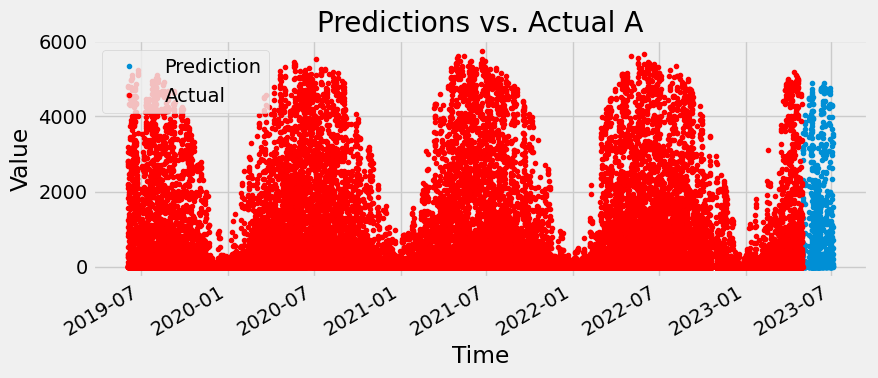

In [129]:
loc_a.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_a['prediction'].plot(style='.', label='Prediction')
train_a['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual A')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### Plotting B

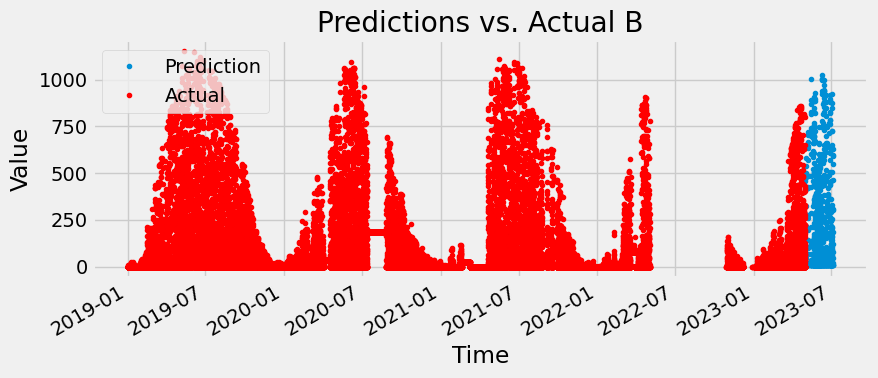

In [130]:
loc_b.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_b['prediction'].plot(style='.', label='Prediction')
train_b['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual B')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


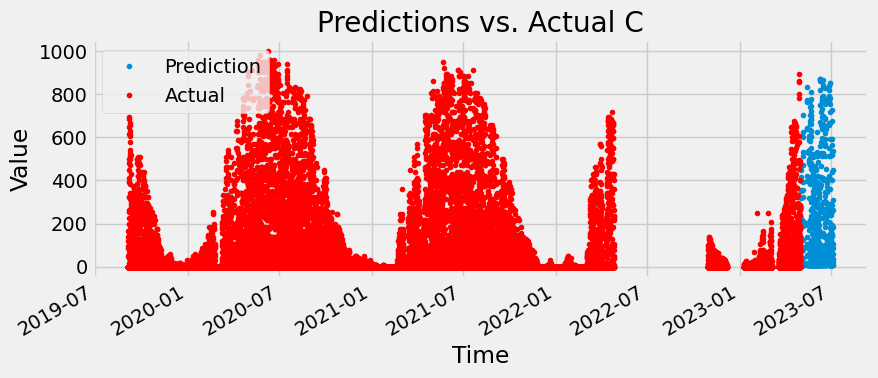

In [131]:
loc_c.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_c['prediction'].plot(style='.', label='Prediction')
train_c['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual C')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()